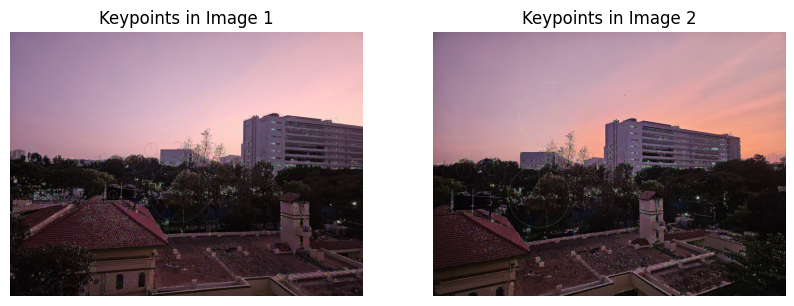

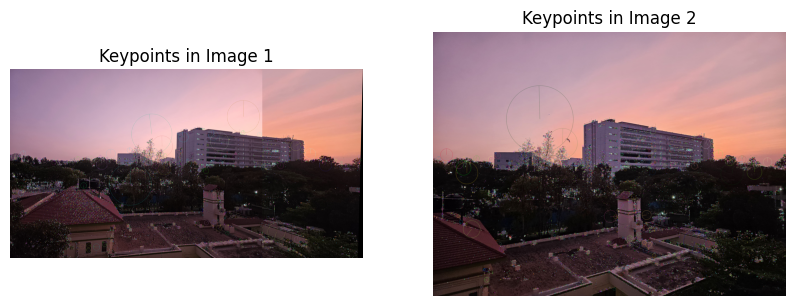

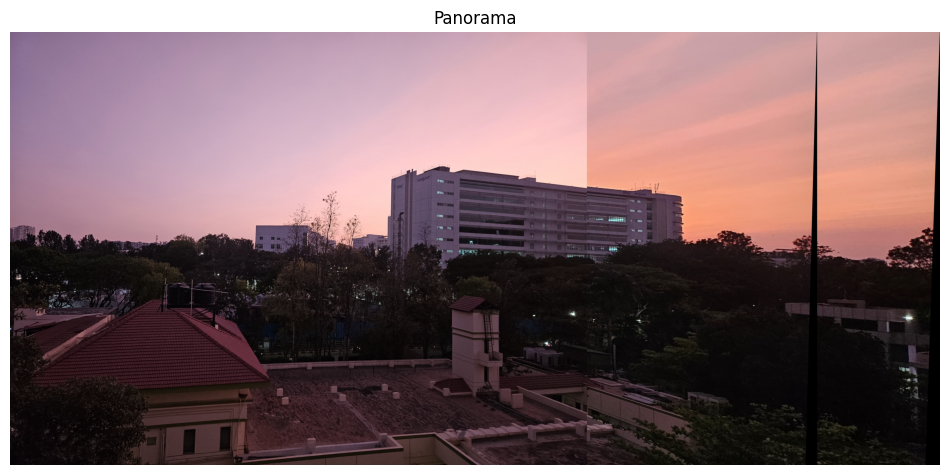

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_match_features(img1, img2):
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    img1_with_keypoints = cv2.drawKeypoints(img1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_with_keypoints = cv2.drawKeypoints(img2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title("Keypoints in Image 1")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title("Keypoints in Image 2")
    plt.axis("off")
    plt.show()

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)

    points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    return points1, points2, matches

def stitch_images(img1, img2):
    points1, points2, matches = detect_and_match_features(img1, img2)

    H, _ = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    # Warp img2 to align with img1
    warped_img2 = cv2.warpPerspective(img2, H, (width1 + width2, max(height1, height2)))

    # Blend images to minimize seams
    stitched = warped_img2.copy()
    stitched[0:height1, 0:width1] = img1

    # Trim black borders
    gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    stitched = stitched[y:y+h, x:x+w]

    return stitched

def main():
    images = ["/content/image2.jpg", "/content/image1.jpg", "/content/image3.jpg"]  # Replace with actual file paths

    img1 = cv2.imread(images[0])
    img2 = cv2.imread(images[1])
    img3 = cv2.imread(images[2])

    stitched = stitch_images(img2, img1)  # Stitch left to center
    stitched = stitch_images(stitched, img3)  # Stitch right to result

    cv2.imwrite("panorama.jpg", stitched)

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Panorama")
    plt.show()

if __name__ == "__main__":
    main()
